In [1]:
#from matplotlib import style (Recommended to use what we learned instead)
#style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Data Analysis tools
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Connecting to the SQLite Database using SQLAlchemy: create engine to hawaii.sqlite 
engine = create_engine("sqlite:///hawaii.sqlite")

In [4]:
# INSPECT

# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# print metadata for each table
for table in tables:
    print(table)
    print("-----------")
    
    # get columns
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

measurement
-----------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
-----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [5]:
# reflect an existing database into a new model
# reflect the tables
# View all of the classes that automap found
# Save references to each table
# Create our session (link) from Python to the DB

In [6]:
# Reflect the database tables into classes using the declared Base class 
Base = automap_base()
Base.prepare(autoload_with=engine)

# Print classes mapped to the Base
print(list(Base.classes))

[<class 'sqlalchemy.ext.automap.station'>, <class 'sqlalchemy.ext.automap.measurement'>]


In [7]:
#print all the classes mapped to the Base
Base.classes.keys()

['station', 'measurement']

In [8]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create a session
session = Session(engine)

In [10]:
# Perform your data analysis and exploration using the session
# Remember to close the session at the end #session.close()

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
# Other ways taught in class by prof Alexander Booth
query = "SELECT max(date) from measurement"

with engine.connect() as conn:
     print(conn.execute(text(query)).fetchall())

[('2017-08-23',)]


In [12]:
#Using the ORM - Other ways taught in class by prof Alexander Booth
session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all()

[('2017-08-23',)]

In [13]:
# Reflect data as panda dataframe
query = """
    SELECT
        date,
        station,
        prcp
    FROM
        measurement
    WHERE
        date >= '2016-08-23'
    ORDER BY
        date ASC;
"""

df = pd.read_sql(text(query), con=engine)
df.head()

,date,station,prcp
0,2016-08-23,USC00519397,0.00
1,2016-08-23,USC00513117,0.15
2,2016-08-23,USC00514830,0.05
3,2016-08-23,USC00517948,NaN
4,2016-08-23,USC00519523,0.02


In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. ##Taught in class.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
start_date = dt.date(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.station, Measurement.prcp).\
    filter(Measurement.date >= start_date).\
    order_by(Measurement.date.asc()).\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_prcp = pd.DataFrame(results, columns=["Date", "Station", "Precipitation"])

# Sort the dataframe by date
df_prcp["Date"] = pd.to_datetime(df_prcp['Date'])
df_prcp = df_prcp.sort_values(by="Date", ascending=True).reset_index(drop=True)

# Use Pandas Plotting with Matplotlib to plot the data
df_prcp.head()

,Date,Station,Precipitation
0,2016-08-23,USC00519397,0.00
1,2016-08-23,USC00513117,0.15
2,2016-08-23,USC00514830,0.05
3,2016-08-23,USC00517948,NaN
4,2016-08-23,USC00519523,0.02


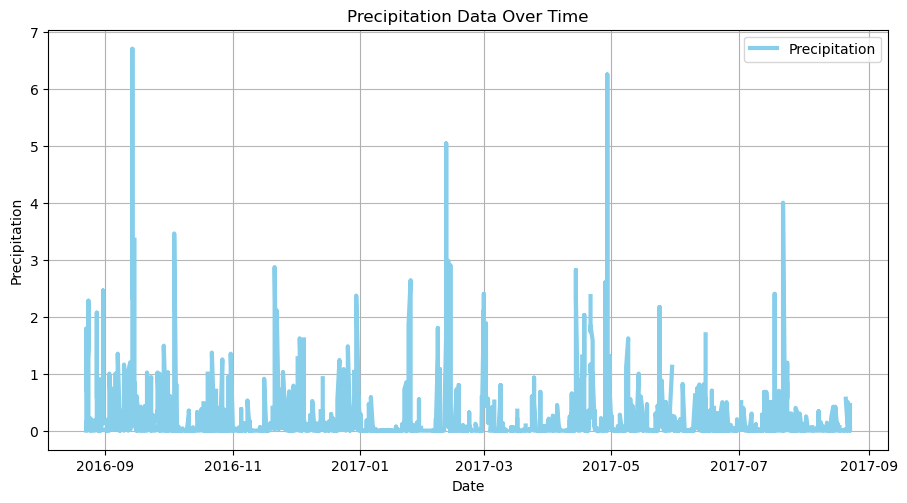

In [15]:
# Use Pandas to calculate summary statistics for the precipitation data
summary_stats = df_prcp['Precipitation'].describe()

# Plot the precipitation data
plt.figure(figsize=(12, 6))
plt.plot(df_prcp['Date'], df_prcp['Precipitation'], color='skyblue', label='Precipitation', linewidth=3, linestyle='-') 
plt.xlabel('Date', fontsize=10)  
plt.ylabel('Precipitation', fontsize=10) 
plt.title('Precipitation Data Over Time', fontsize=12) 

# Adding Legends
plt.legend(fontsize=10) 
plt.grid(axis='y', alpha=0.9) 

# Add grid lines to the plot
plt.grid(True)

# Adjusting Figure Layout
plt.subplots_adjust(left=0.3, right=1.0, top=1.0, bottom=0.3)
plt.show()

In [16]:
# Print the summary statistics
print(summary_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
query = """
    SELECT COUNT
        (DISTINCT station) AS total_stations
    FROM station;
"""

df = pd.read_sql(text(query), con=engine)
df.head()

,total_stations
0,9


In [18]:
# Query the station data and convert it to a DataFrame
station_data = session.query(Station).all()
df_stations = pd.DataFrame([vars(station) for station in station_data])

# Calculate the total number of stations in the dataset
total_stations = df_stations['station'].nunique()

print("Total number of stations in the dataset:", total_stations)

df_stations.info()

Total number of stations in the dataset: 9
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   _sa_instance_state  9 non-null      object 
 1   id                  9 non-null      int64  
 2   latitude            9 non-null      float64
 3   elevation           9 non-null      float64
 4   longitude           9 non-null      float64
 5   name                9 non-null      object 
 6   station             9 non-null      object 
dtypes: float64(3), int64(1), object(3)
memory usage: 632.0+ bytes


In [19]:
# Panda station name list 
df_stations["station"].tolist()

['USC00519397',
 'USC00513117',
 'USC00514830',
 'USC00517948',
 'USC00518838',
 'USC00519523',
 'USC00519281',
 'USC00511918',
 'USC00516128']

In [20]:
# Station name List
station_names_list = df_stations["station"].tolist()
print("List of Station Names:")
print(station_names_list)

List of Station Names:
['USC00519397', 'USC00513117', 'USC00514830', 'USC00517948', 'USC00518838', 'USC00519523', 'USC00519281', 'USC00511918', 'USC00516128']


In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
Station_counts = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
Station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Design a query to find the most active stations (i.e. which stations have the most rows?) other way
# List the stations and their counts in descending order.

most_active_stations_query = """
        SELECT 
            station, COUNT(*) AS observation_count
        FROM 
            measurement
        GROUP BY 
            station
        ORDER BY 
            observation_count DESC;
"""
df = pd.read_sql_query(text(most_active_stations_query), con=engine)
df.head()

# COUNT(*) counts the number of rows for each station.
# GROUP BY station groups the results by station.
# ORDER BY station_count DESC sorts the stations and their counts in descending order based on the count of rows.


,station,observation_count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station==Station_counts[0][0]).all()
most_active_station

[(54.0, 85.0, 71.66378066378067)]

In [24]:
# Execute the query -- Other way to show same above results
most_active_station = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == Station_counts[0][0])\
    .all()

# Create a DataFrame from the query result
df_most_active_station = pd.DataFrame(most_active_station, columns=['Min TOBS', 'Max TOBS', 'Avg TOBS'])

# Display the DataFrame
df_most_active_station

,Min TOBS,Max TOBS,Avg TOBS
0,54.0,85.0,71.663781


<Figure size 800x600 with 0 Axes>

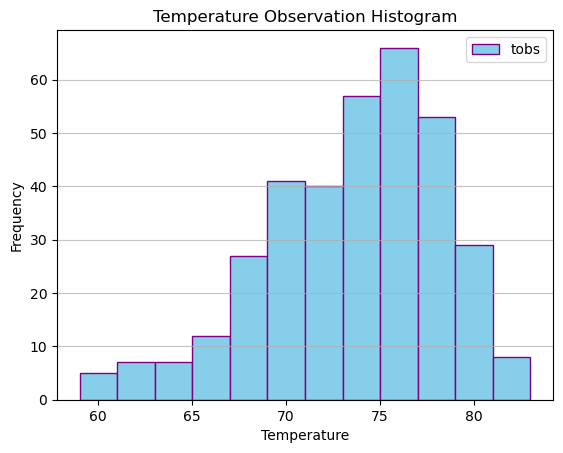

In [25]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
time_frame = dt.date(2017, 8, 23) - dt.timedelta(days=365)

precipitation=session.query(Measurement.tobs).filter(Measurement.station==Station_counts[0][0]).filter(Measurement.date>=time_frame).all()

df=pd.DataFrame(precipitation,columns=["tobs"])

# Plot the histogram with customizations
plt.figure(figsize=(8, 6))  

# Plot the histogram
df.plot.hist(bins=12, color='skyblue', edgecolor='purple')
plt.xlabel("Temperature")
plt.grid(axis='y', alpha=0.75) 
plt.title("Temperature Observation Histogram")  
plt.show()

# Close Session

In [26]:
# Close Session
session.close()